# Figures for paper

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


---

## Set gradient version

In [3]:
pca = gradientVersion(approach='pca').fit('hcp_base')
pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=pca, params={}, kernel=normalized_angle, sparsity=0, data=hcp_base
New gradients version: method=pca, params={}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds8
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds9
New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [4]:
hcp_version = dm_hcp_ds9

---

## 1 — Gradients on brains

In [ ]:
hcp_scores = (pd.concat({
    'PCA, all regions and genes': pca.clean_scores(),
    'PCA, only 3+ donor regions,\ntop 20% DS genes': pca_hcp_3d_ds8.clean_scores(),
    'DM, only 3+ donor regions,\ntop 50% DS genes': dm_hcp_3d_ds5.clean_scores(),
    'DM, all regions,\ntop 10% DS genes': dm_hcp_ds9.clean_scores()
    # 'DM, only top 10% DS genes,\nall regions': dm_hcp_ds9.clean_scores(),
})
        .reset_index(level=0).rename({'level_0':'version'},axis=1)
         )

## 1 — Triplets filtering

Load triplets data from pickles since triplets are slow to compute

In [ ]:
triplets_hcp = load_pickle('triplets_hcp')
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')

In [118]:
triplets_pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
triplets_pca_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [5]:
# triplets_dict = {
#     'PCA, all regions': triplets_pca, 
#     'PCA, only 3+ donor regions': triplets_pca_3d,
#     'DM, only 3+ donor regions': triplets_dm_3d,
#     'DM, all regions': triplets_dm
# }
# save_pickle(triplets_dict, 'triplets_dict')
triplets_dict = load_pickle('triplets_dict')

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )

df_triplets_highlight = pd.DataFrame({'method': triplets_dict.keys(), 'DS':[0,.8,.5,.9]}).assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))

In [7]:
hcp_scatter = (hcp_scores.set_index(['version', 'label']).stack().unstack(0)
               .iloc[:,[0,1]].reset_index(1).set_axis(['G','x','y'],axis=1)
              )

# Fig 1

Message: With careful processing, PC2 and PC3 of the AHBA are robust and generalizable.

Enabled features: cairo, fontconfig, freetype, fftw, pango, rsvg, webp, x11
Disabled features: ghostscript, heic, lcms, raw






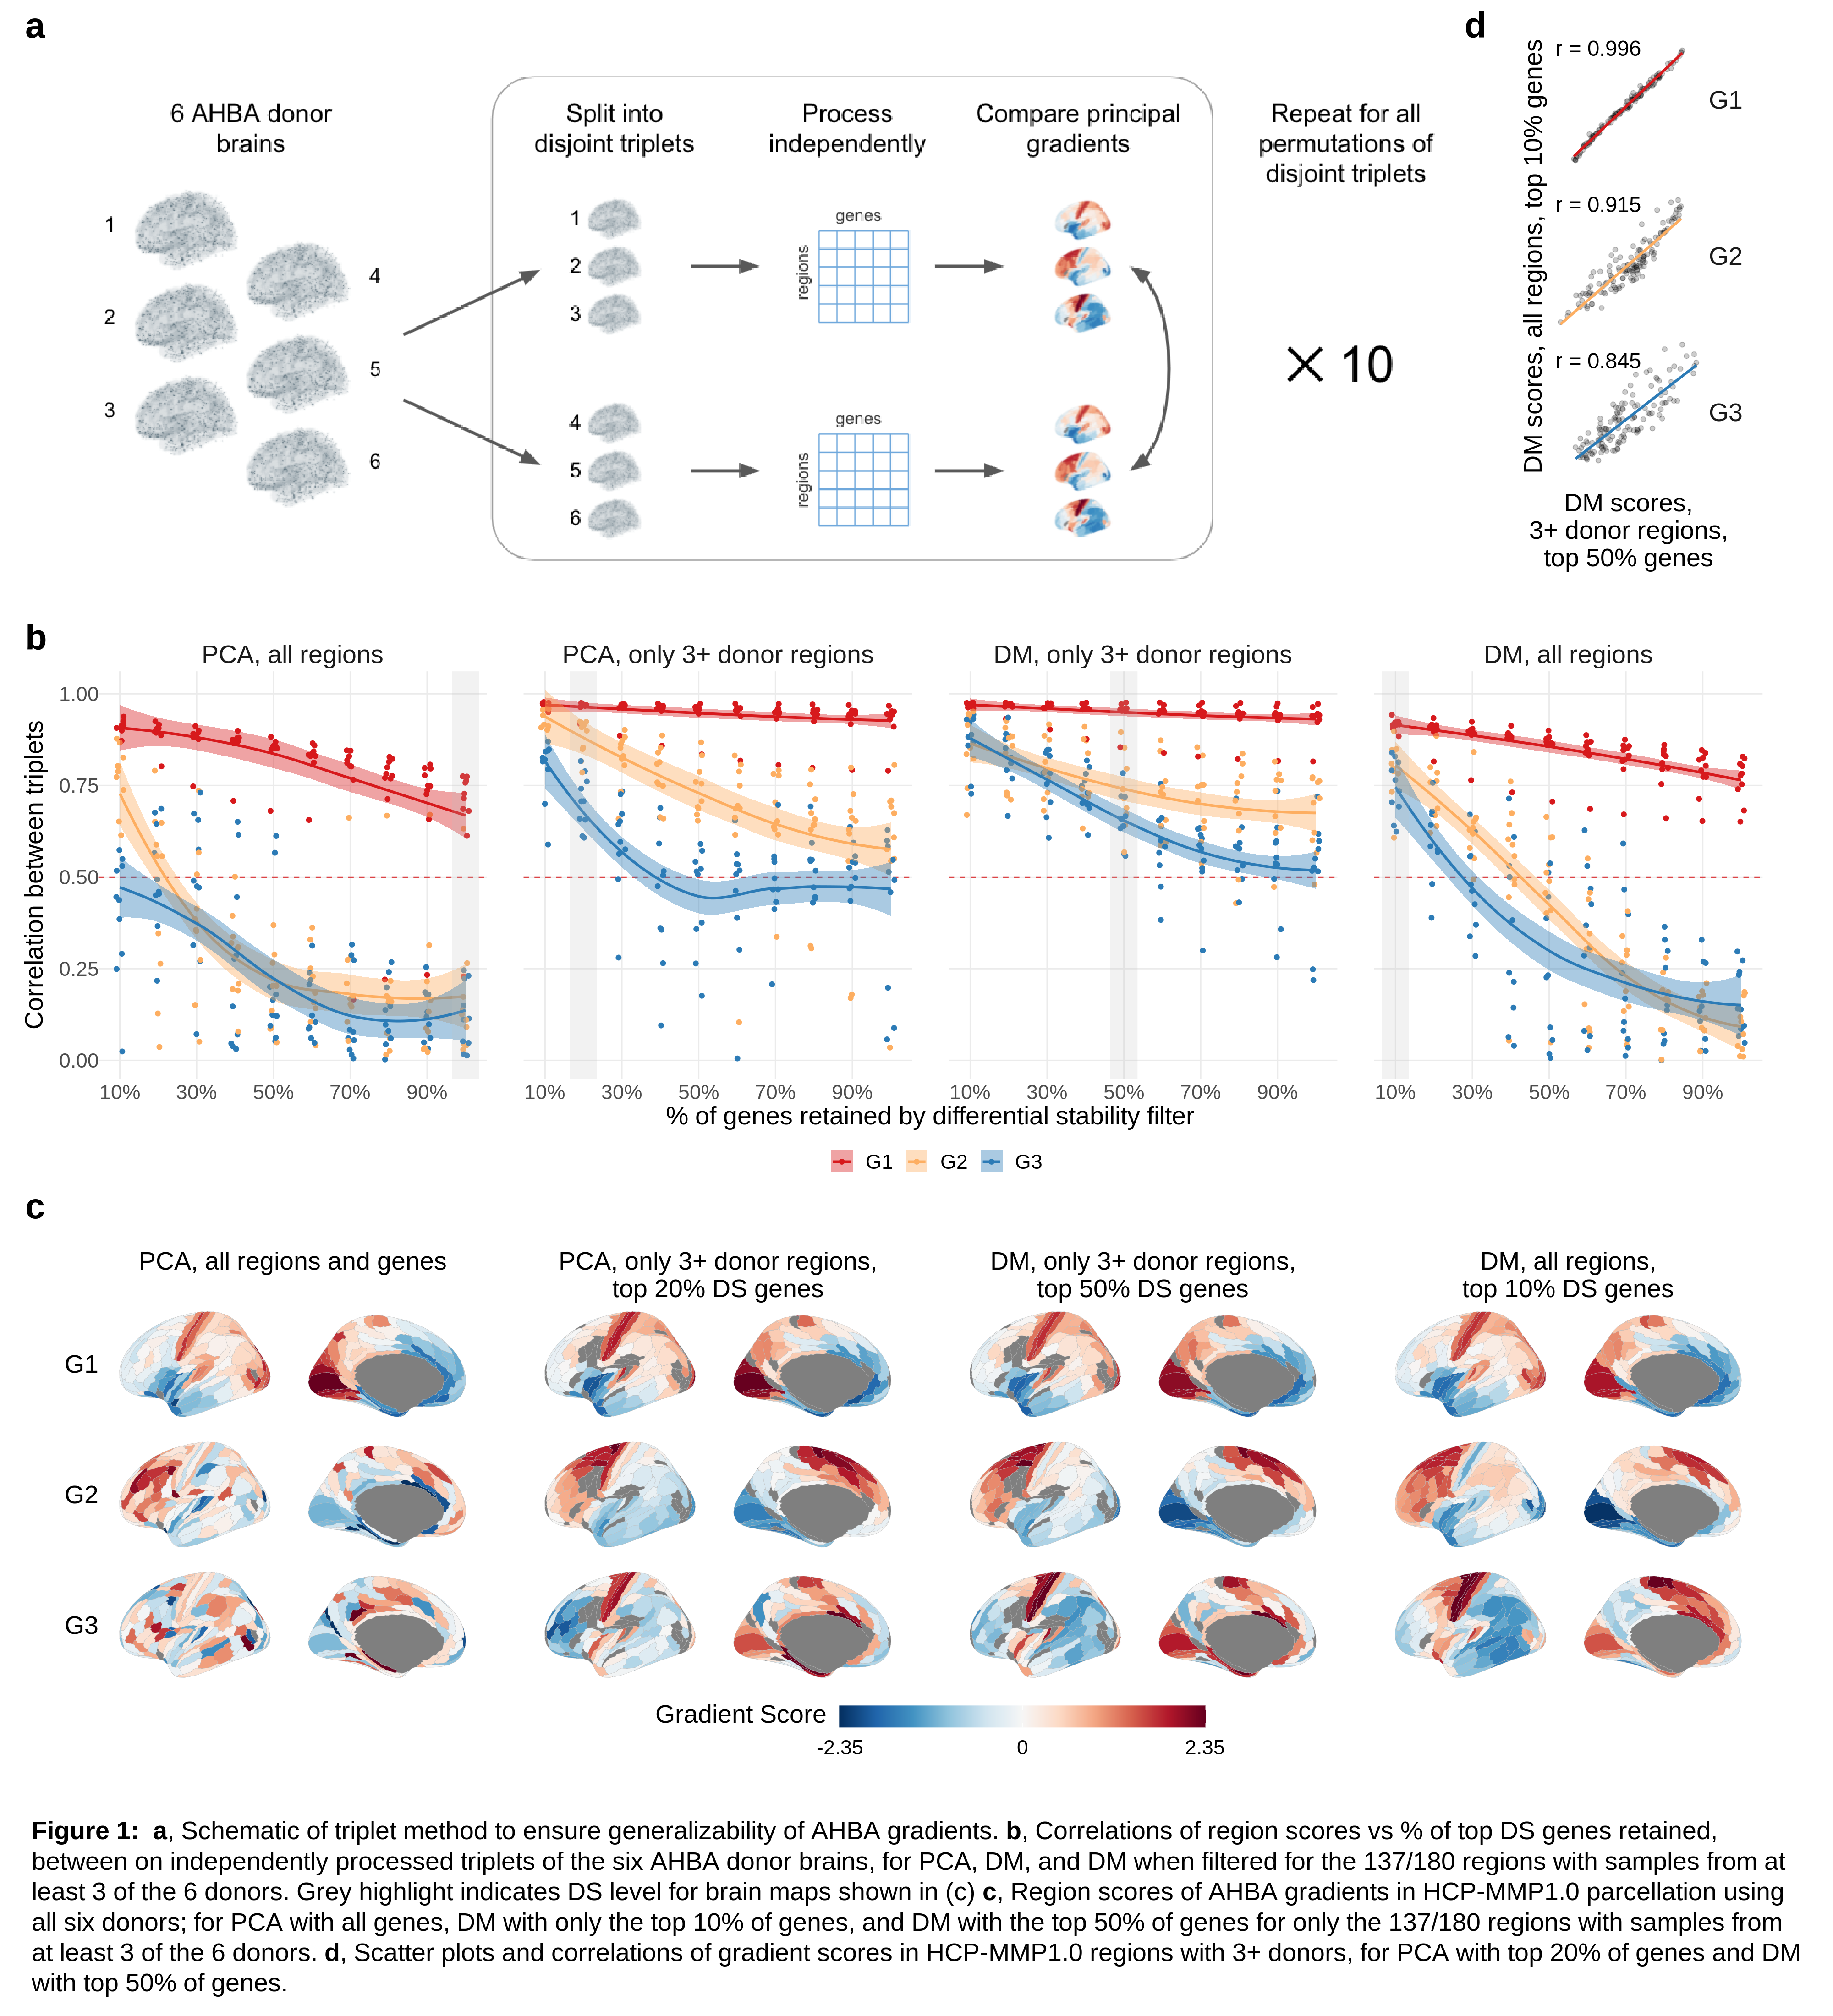

In [9]:
%%R -w 20 -h 22 --units in -r 200 -i triplets_plot_v2 -i hcp_scores -i df_triplets_highlight -i hcp_scatter
source("../code/Rplots.R")
source("../code/brainPlots.R")
# source("../code/brainspanPlots.R")
library(magick)
img <- image_read("../data/schematics/fig1_schem.png")

g0 <- image_ggplot(img)
g2 <- plot_triplets_v2(triplets_plot_v2, facet='h') + geom_vline(data=df_triplets_highlight, aes(xintercept=DS), size=10, alpha=.2, color='grey') +
    theme(axis.text.y=element_text(margin=margin(r=-40))
          # axis.title.y=element_text(margin=margin(r=-10))
         )
# g3a <- plot_hcp(hcp_scores %>% filter(str_detect(version, 'PCA')), spacing_x=2) + theme(legend.position='none', strip.text.y=element_text(margin=margin(l=10)))
# g3b <- plot_hcp(hcp_scores %>% filter(str_detect(version, 'DM')), spacing_x=2) + theme(legend.position='bottom', strip.text.y=element_text(margin=margin(l=10))) + 
#         guides(fill=guide_colorbar(title='Score', barwidth=10, title.vjust=1)) + plot_layout(tag_level='new')
g3 <- plot_hcp(hcp_scores, spacing_x=2, switch='y') + 
    guides(fill=guide_colorbar(barwidth=20, title='Gradient Score', title.vjust=1)) +
    theme(strip.text.y=element_text(margin=margin(l=10)))
g4 <- plot_scatter_corrs(hcp_scatter, xlab='DM scores,\n3+ donor regions,\ntop 50% genes', ylab='DM scores, all regions, top 10% genes')

caption <- paste("**Figure 1:**",
                "**a**, Schematic of triplet method to ensure generalizability of AHBA gradients.",
                "**b**, Correlations of region scores vs % of top DS genes retained, between on independently processed triplets of the six AHBA donor brains, for PCA, DM, and DM when filtered for the 137/180 regions with samples from at least 3 of the 6 donors.",
                        "Grey highlight indicates DS level for brain maps shown in (c)",
                "**c**, Region scores of AHBA gradients in HCP-MMP1.0 parcellation using all six donors; for PCA with all genes, DM with only the top 10% of genes, and DM with the top 50% of genes for only the 137/180 regions with samples from at least 3 of the 6 donors.",
                "**d**, Scatter plots and correlations of gradient scores in HCP-MMP1.0 regions with 3+ donors, for PCA with top 20% of genes and DM with top 50% of genes."
)


layout <- c(
  area(t = 1, b = 18, l = 1, r = 40),
  area(t = 19, b = 33, l = 1, r = 48),
  area(t = 34, b = 48, l = 1, r = 48),
  # area(t = 6, b = 7, l = 6, r = 10),
  area(t = 1, b = 17, l = 41, r = 48)
)

plot <- g0 + g2 + g3 + g4 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20), 
    strip.text=element_text(size=20),
    strip.text.x=element_text(size=20),
    strip.text.y=element_text(size=20),
    plot.margin = margin(t=10, r=10, b=10, l=10, "pt"),
    plot.tag.position = c(0, 1),
    plot.tag = element_text(size=28, face='bold', hjust=0)
)


annotated <- themed + plot_annotation(
  tag_level='a',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated
# ggsave(filename='test2.png', device='png')

---

# Fig 2 — maps

In [5]:
maps=get_maps()
hcp_scores = dm_hcp_ds9.clean_scores()
corrs = get_corrs(hcp_scores, maps, method='pearson')

In [6]:
sim_grads = np.load("../outputs/permutations/sim_gradients_1000.npy")
null_corrs = corr_nulls_from_grads(sim_grads, hcp_scores, maps, method='pearson')
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [7]:
short_names = {
        'Myelination (T1w/T2w)':'T1w/T2w',
        'Cortical Thickness (CT)':'CT',
        'fMRI PC1':'fMRI PC1',
        'Oxygen Metabolism (CMRO2)':'CMRO2',
        'Glucose Metabolism (CMRGlu)':'CMRGlu',
        'Glycolytic Index (AG)':'AG',
        'Developmental Expansion (Dev. Exp.)':'Dev. Exp.',
        'Evolutionary Expansion (Evo. Exp.)':'Evo. Exp.',
        'Externopyramidisation (Externo.)':'Externo.',
        'Cerebral Blood Flow (CBF)':'CBF',
        'Allometric Scaling (Allom.)':'Allom.',
        'NeuroSynth PC1 (NS PC1)':'NS PC1',
}
null_p = null_p.assign(map_name = lambda x: x['map'].map(short_names))

## Scatter

In [8]:
maps_scatter_names = {
    # 'Myelination (T1w/T2w)':'Myelination\n(T1w/T2w)',
    'Oxygen Metabolism (CMRO2)':'Oxygen\nMetabolism',
    'Glycolytic Index (AG)':'Glycolytic\nIndex'
}
maps_scatter = (maps
                .loc[:,maps_scatter_names.keys()]
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(hcp_scores.set_index('label')).reset_index()
                .replace({'map':maps_scatter_names})
                .drop('G3',axis=1)
               )
maps_scatter_corrs = (null_p.query("map in @maps_scatter_names.keys()")
                      .loc[:,['map','G','true_mean','q']]
                      .replace({'map':maps_scatter_names})
                      .loc[lambda x: x['G'] != 'G3']
                     )

## PCA

In [9]:
pca_scores, pca_weights = maps_pca(maps, short_names)
pca_scores = (pca_scores.drop('PC3', axis=1).loc[:,['PC2','PC1']] * [1,-1]).reset_index()

In [10]:
ahba_scores = hcp_scores.drop('G3', axis=1)

In [11]:
both_scores_scatter = (pd.concat({
    'MRI PCA': pca_scores.set_axis(['label','G1','G2'],axis=1).set_index('label'),
    'AHBA DM': ahba_scores.set_index('label')}, 
    axis=1)
 .stack(1).reset_index().rename({'level_1':'G'},axis=1)
 .replace({'G':{'G1':'AHBA G1 v MRI PC2', 'G2':'AHBA G2 v MRI PC1'}})
)

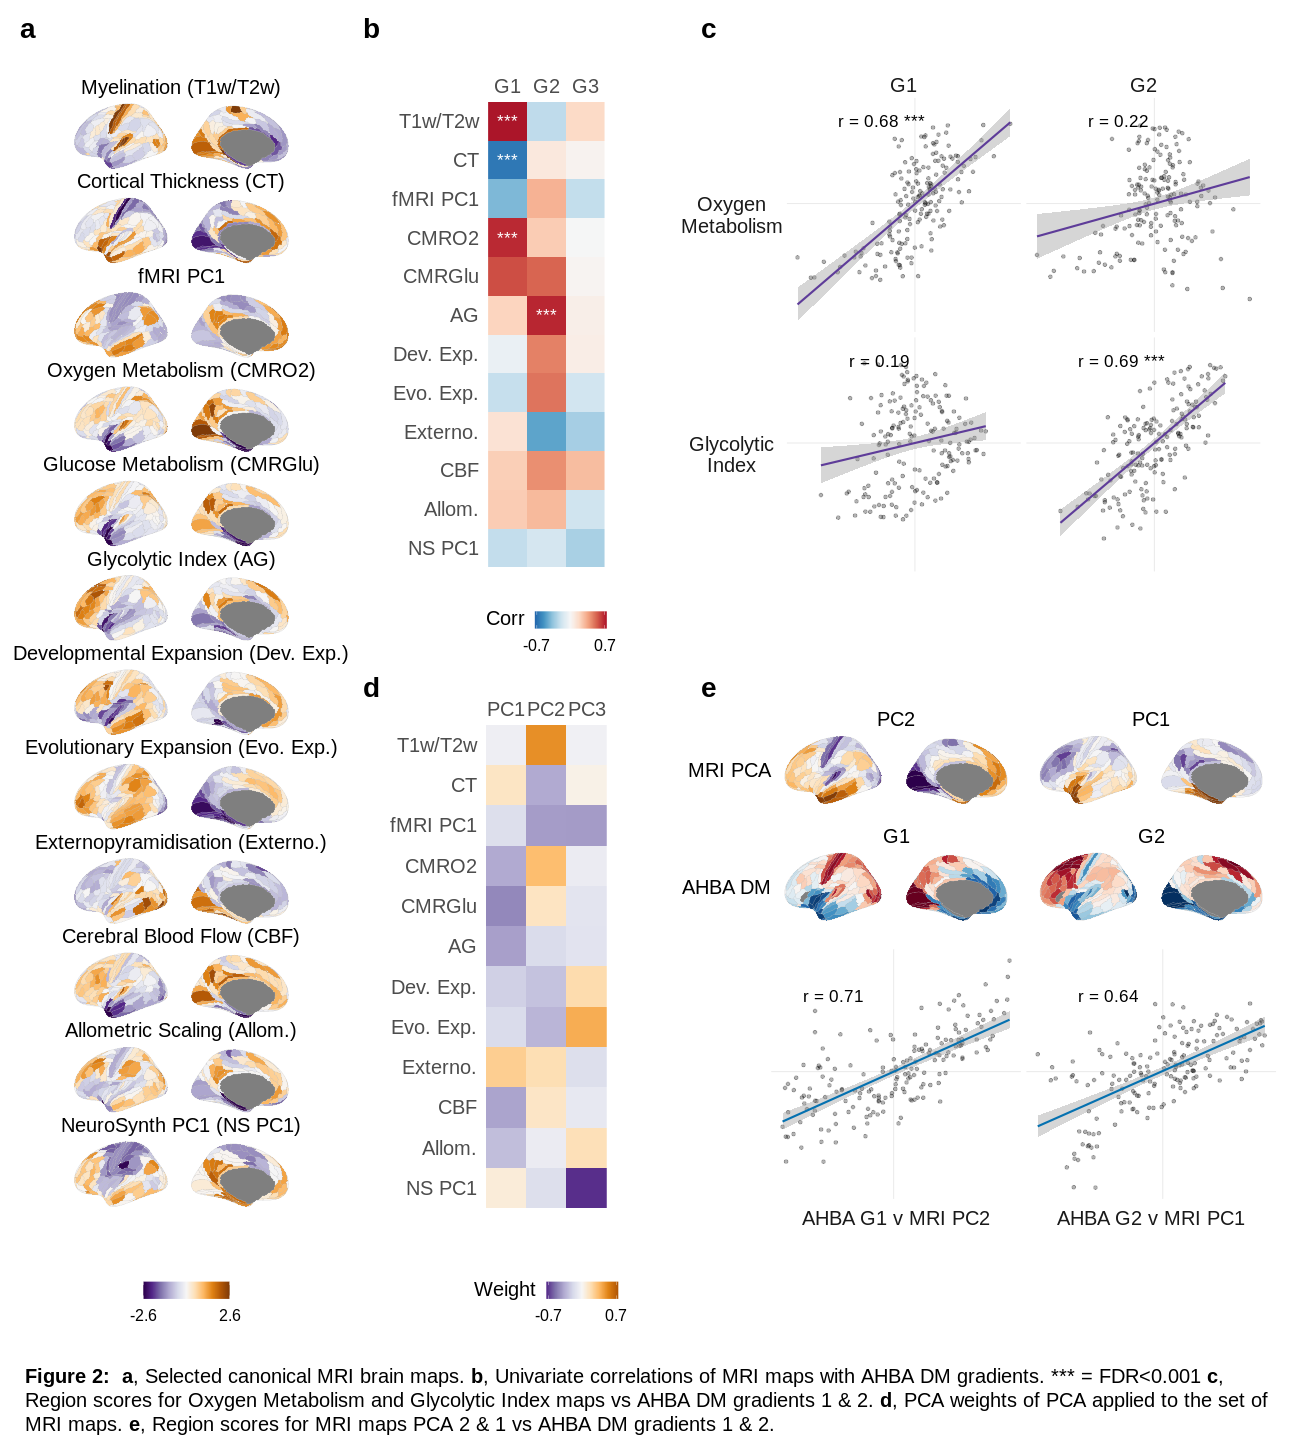

In [23]:
%%R -w 18 -h 20 --units in -i maps -i null_p -i maps_scatter -i maps_scatter_corrs -i pca_weights -i pca_scores -i ahba_scores -i both_scores_scatter
source("../code/plot_maps.R") 

g1 <- plot_maps(maps, ncol=1, colors=rev(brewer.puor(100)), spacing=0) + theme(legend.position='bottom', plot.tag.position = c(0, 1))
g2 <- plot_map_corrs(null_p) + theme(plot.tag.position = c(0, 1))
g3 <- plot_maps_scatter(maps_scatter, maps_scatter_corrs) + theme(plot.tag.position = c(0.1, 1))
g4 <- plot_pca_weights(pca_weights) + theme(plot.tag.position = c(0, 1))
g5a <- plot_ahba_mri_brains(pca_scores %>% mutate(version='MRI PCA'), colors=brewer.puor(100)) + theme(plot.tag.position = c(0.1, 1))
g5b <- plot_ahba_mri_brains(ahba_scores %>% mutate(version='AHBA DM')) + plot_layout(tag_level='new')
g6 <- plot_both_scores_scatter(both_scores_scatter) + plot_layout(tag_level='new')

layout <- c(
  # All maps
  area(t = 1, b = 48, l = 1, r = 16),
  # All corrs
  area(t = 1, b = 24, l = 17, r = 23),
  # Scatter corrs
  area(t = 1, b = 24, l = 24, r = 48),
  # area(t = 1, b = 12, l = 21, r = 48),
  # area(t = 13, b = 24, l = 21, r = 48),
  # PCA weights
  area(t = 25, b = 48, l = 17, r = 23),
  # PCA brains
  area(t = 25, b = 29, l = 24, r = 48),
  # AHBA brains
  area(t = 30, b = 34, l = 24, r = 48),
  # PCA-AHBA scatter
  area(t = 35, b = 48, l = 24, r = 48)

)

plot <- g1 + g2 + g3 + g4 + g5a + g5b + g6 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20),
    plot.margin = margin(t=0, b=0, l=10, r=10, "pt"),
    plot.tag = element_text(size=28, face='bold', vjust=2, hjust=0)
)

caption <- paste("**Figure 2:**",
                 "**a**, Selected canonical MRI brain maps.",
                 "**b**, Univariate correlations of MRI maps with AHBA DM gradients. *** = FDR<0.001",
                 "**c**, Region scores for Oxygen Metabolism and Glycolytic Index maps vs AHBA DM gradients 1 & 2.",
                 "**d**, PCA weights of PCA applied to the set of MRI maps.",
                 "**e**, Region scores for MRI maps PCA 2 & 1 vs AHBA DM gradients 1 & 2."
)

annotated <- themed + plot_annotation(
  tag_level='a',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

# Fig 3

In [43]:
weights_version = dm_hcp_3d_ds5

In [40]:
weights = weights_version.weights.iloc[:,:3]
nulls = shuffle_gene_weights(weights, n=10000, rank=False)

## Gene weight vs DS

In [42]:
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')
weights_ds = weights.set_axis(['G1','G2','G3'],axis=1).join(stability)

## Brainspan mapping

In [38]:
hcp_bs_mapping = get_hcp_bs_mapping()

In [41]:
bs_exp, bs_col, bs_row = get_brainspan()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, hcp_bs_mapping)
bs_agg = aggregate_brainspan_by_age(bs_clean)

## Brainspan development

In [44]:
hcp_mapped_scores = get_mapped_scores(weights_version, hcp_bs_mapping)
bs_scores = compute_brainspan_scores(bs_agg, weights_version)

In [45]:
age_groups = get_age_groups()
bs_scores_corr = correlate_brainspan_scores(bs_scores, hcp_mapped_scores, age_groups=age_groups)

## Brainspan adult correlation

In [46]:
both_scores, both_corrs = combine_scores(bs_scores, hcp_mapped_scores, age_groups)

In [48]:
scores_plot = make_brain_plots(weights_version, hcp_bs_mapping, bs_scores)

## Burt genes

In [94]:
burt_genes = ['CORT','CALB1','SST','PVALB','CCK','NPY','PNOC','CALB2','VIP']
burt_genes = pd.DataFrame({'Gene':burt_genes, 'Class':burt_genes})
gene_maps = make_gene_maps(weights_version, burt_genes, normalize='std', method='mean')
gene_map_corrs = weights_version.clean_scores().set_index('label').join(gene_maps).corr(method='spearman').iloc[3:,:3]

## Cell enrichments

In [48]:
cell_genes = get_cell_genes(which='jakob')
order = ['Neuro-Ex', 'Neuro-In', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC']
gene_masks = match_cell_genes(cell_genes, weights)
true_scores, null_scores = compute_cell_scores(weights, nulls, gene_masks, how='mean')
cell_null_p = compute_null_p(true_scores, null_scores, adjust='fdr_bh', order=order)

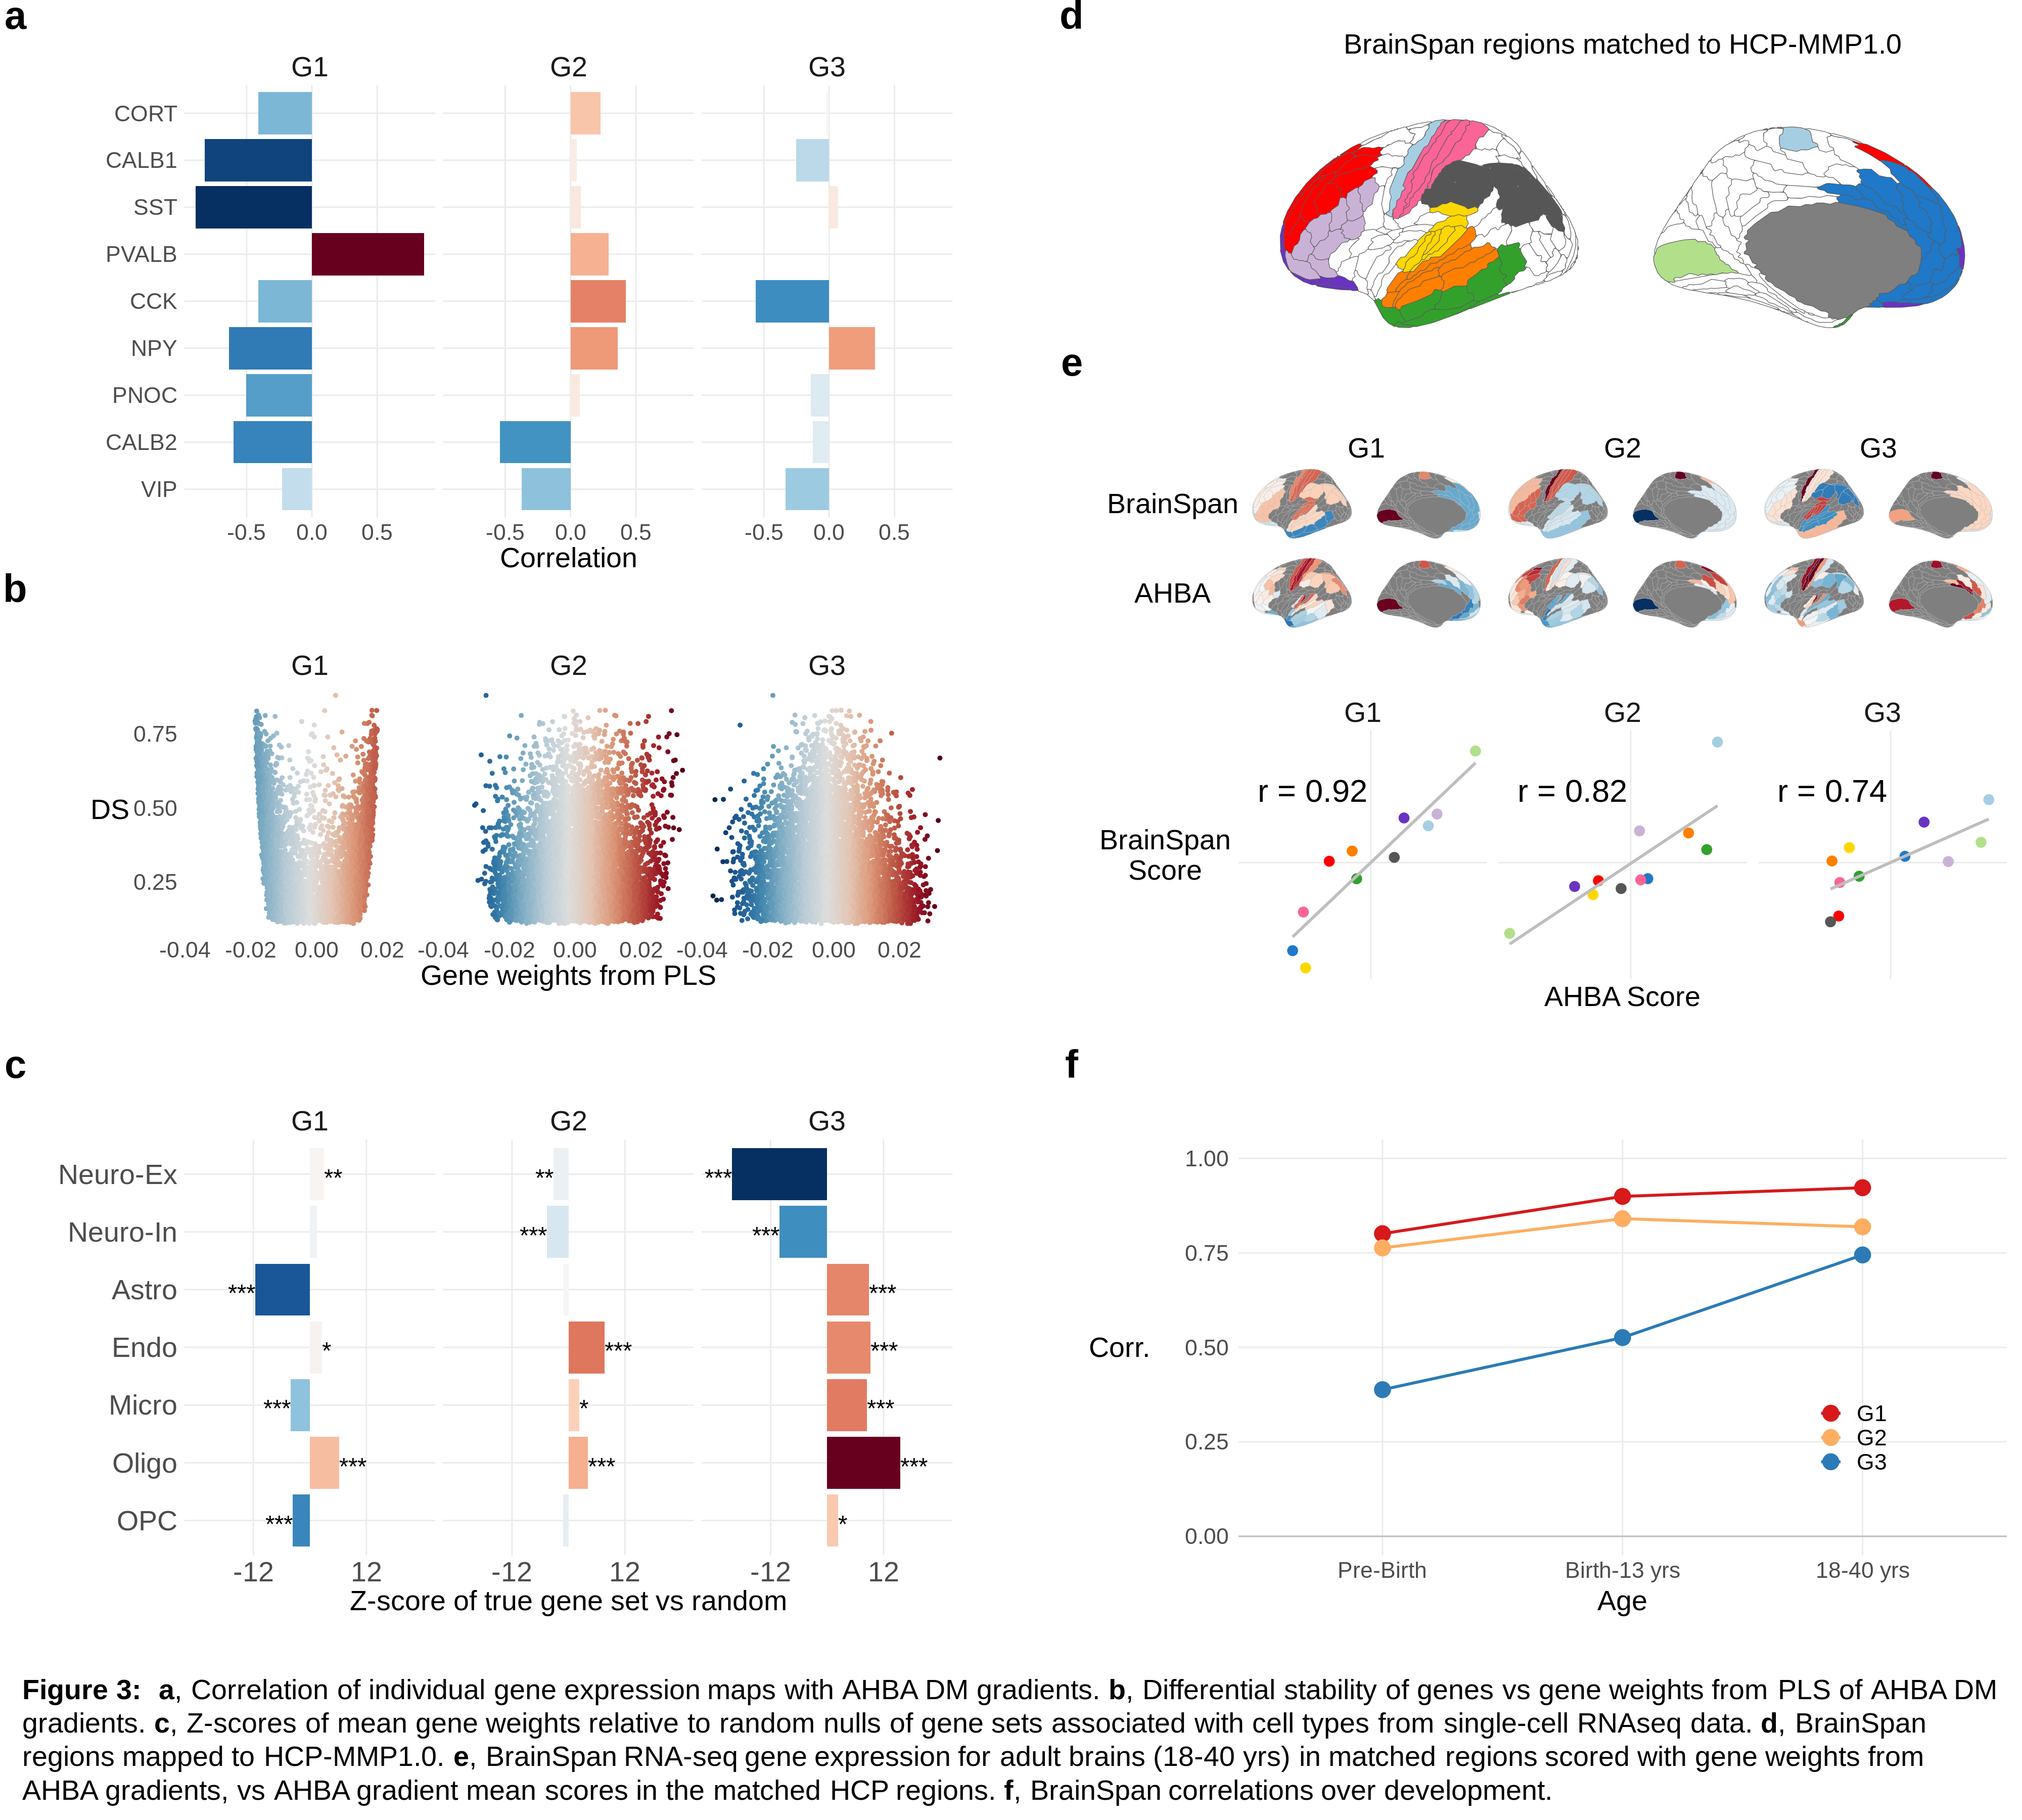

In [112]:
%%R -w 20 -h 18 --units in -r 200 -i weights_ds -i genes_null_p -i cell_null_p -i hcp_bs_mapping -i cortex_scores -i cortex_corrs -i scores_plot -i bs_scores_corr
source("../code/Rplots.R")
source("../code/enrichmentsPlots.R")
source("../code/brainspanPlots.R")
source("../code/brainPlots.R")

g0 <- plot_burt_bars(gene_map_corrs) + theme(plot.tag.position = c(0, 1))
g1 <- plot_weights_ds(weights_ds) + theme(plot.tag.position = c(0, 1))
g2 <- plot_cell_bars(cell_null_p) + theme(plot.tag.position = c(0, 1))

g10 <- plot_bs_mapping(hcp_bs_mapping) + theme(plot.tag.position = c(0.1, 1))
g11 <- plot_hcp(scores_plot, facet='v', switch='y') + theme(
            strip.text.x=element_text(size=20), 
            strip.text.y.left=element_text(size=20),
            legend.position='none',
            plot.tag.position = c(0.1, 1)
            )
g12 <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs, facet='h', size=3) + plot_layout(tag_level='new')
g13 <- plot_bs_scores_corr(bs_scores_corr) + 
    theme(
        axis.text.y=element_text(margin=margin(r=-90, unit='pt')),
        axis.title.y=element_text(margin=margin(r=-120, unit='pt'), angle=0, vjust=0.5),
        text=element_text(size=20), legend.position=c(.8,.3),  
        plot.tag.position = c(0.1, 1)
        )

layout <- c(
    area(t=1,b=16,l=1,r=1),
    area(t=17,b=30,l=1,r=1),
    area(t=31,b=48,l=1,r=1),
    
    area(t=1,b=12,l=2,r=2),
    area(t=13,b=18,l=2,r=2),
    area(t=19,b=30,l=2,r=2),
    area(t=31,b=48,l=2,r=2)
)
    
plot <- g0 + g1 + g2 + g10 + g11 + g12 + g13 + plot_layout(design=layout)


caption <- paste("**Figure 3:**",
                "**a**, Correlation of individual gene expression maps with AHBA DM gradients.",
                "**b**, Differential stability of genes vs gene weights from PLS of AHBA DM gradients.",
                "**c**, Z-scores of mean gene weights relative to random nulls of gene sets associated with cell types from single-cell RNAseq data.",
                "**d**, BrainSpan regions mapped to HCP-MMP1.0.",
                "**e**, BrainSpan RNA-seq gene expression for adult brains (18-40 yrs) in matched regions scored with gene weights from AHBA gradients, vs AHBA gradient mean scores in the matched HCP regions.",
                "**f**, BrainSpan correlations over development."
)

themed <- plot & theme(
    text=element_text(size=20), 
    strip.text=element_text(size=20),
    strip.text.x=element_text(size=20),
    strip.text.y=element_text(size=20),
    # plot.margin = margin(t=10, r=10, b=10, l=10, "pt"),
    plot.tag = element_text(size=28, face='bold')
)


annotated <- themed + plot_annotation(
  tag_level='a',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated
# ggsave(filename='test2.png', device='png')

---

## Disorder maps

In [45]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


In [189]:
maps = get_disorder_maps().drop(['ADHD', 'ANX', 'MCI'], axis=1)
null_corrs_dict_disorders = load_pickle('null_corrs_dict_disorders')

In [190]:
dk_scores = dm_dk_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(dk_scores, maps, atlas='dk')
null_corrs = null_corrs_dict_disorders['sim_grads_p']

disorder_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

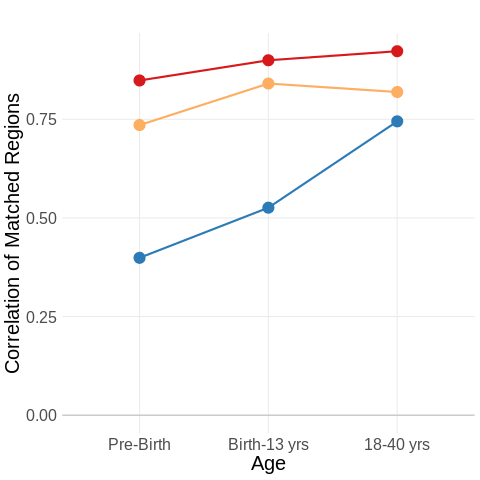

In [331]:
%%R -i bs_scores_corr
source("../code/brainspanPlots.R")
plot_bs_scores_corr(bs_scores_corr) & theme(text=element_text(size=20)) 

---

---

# Supplement

## 1 — Distributions

In [5]:
counts_hcp = pd.read_csv("../outputs/counts_hcp.csv", index_col=0)
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')
donor_counts = (counts_hcp!=0).sum(axis=1)[:180].rename('count').to_frame()

In [6]:
stability['ds'].quantile(.9)

0.3859072493003411

---

## 2 — Parcellations

In [88]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
dm_dx_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dx_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9
New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [89]:
hcp_scores = dm_hcp_ds9.clean_scores().assign(version='HCP-MMP1.0,\ntop 10% DS genes')
dk_scores = dm_dk_ds9.clean_scores().assign(version='Desikan-Killiany,\ntop 10% DS genes')
dx_scores = dm_dx_ds9.clean_scores().assign(version='Desterieux,\ntop 10% DS genes')

## 2 — Parcellation gene weight corrs

In [91]:
corrs_dict = {
    'HCP-MMP1.0,\ntop 10% DS genes': correlate(dm_hcp_ds9.fit_weights(overwrite=False), weights_version.weights),
    'Desikan-Killiany,\ntop 10% DS genes': correlate(dm_dk_ds9.fit_weights(), weights_version.weights),
    'Desterieux,\ntop 10% DS genes': correlate(dm_dx_ds9.fit_weights(), weights_version.weights)
}

weight_corrs = (pd.concat(corrs_dict)
 .melt(ignore_index=False)
 .reset_index()
 .set_axis(['version','x','y','corr'], axis=1)
 .loc[lambda x: (x['x'] < 3) & (x['y'] < 3)]
 .replace({'x':{0:'G1',1:'G2',2:'G3'}, 'y':{0:'G1',1:'G2',2:'G3'}})
)

In [92]:
def count_gene_overlap(v1, v2):
    overlap = set(v1.weights.index).intersection(set(v2.weights.index))
    overlap_v1 = round(len(overlap)/len(v1.weights.index),2)*100
    overlap_v2 = round(len(overlap)/len(v2.weights.index),2)*100
    print(f'Overlap is {overlap_v1}% of v1 genes, {overlap_v2}% of v2 genes')
    
count_gene_overlap(dm_hcp_ds9, dm_dk_ds9)

Overlap is 85.0% of v1 genes, 85.0% of v2 genes


---

## MRI maps

In [187]:
maps = get_maps()#.drop(['Size Variation (allometric scaling)', 'fMRI PC1', 'NeuroSynth PC1'], axis=1)
null_corrs_dict = load_pickle('null_corrs_dict')

In [188]:
hcp_scores = dm_hcp_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(hcp_scores, maps, atlas='hcp')
null_corrs = null_corrs_dict['sim_grads_p']

mri_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## Disorder maps

In [45]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


In [189]:
maps = get_disorder_maps().drop(['ADHD', 'ANX', 'MCI'], axis=1)
null_corrs_dict_disorders = load_pickle('null_corrs_dict_disorders')

In [190]:
dk_scores = dm_dk_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(dk_scores, maps, atlas='dk')
null_corrs = null_corrs_dict_disorders['sim_grads_p']

disorder_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## For plotting brains

In [96]:
maps_to_plot = [
    'Myelination (T1w/T2w ratio)',
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Developmental Expansion'
]

hcp_maps = maps.loc[:, maps_to_plot]

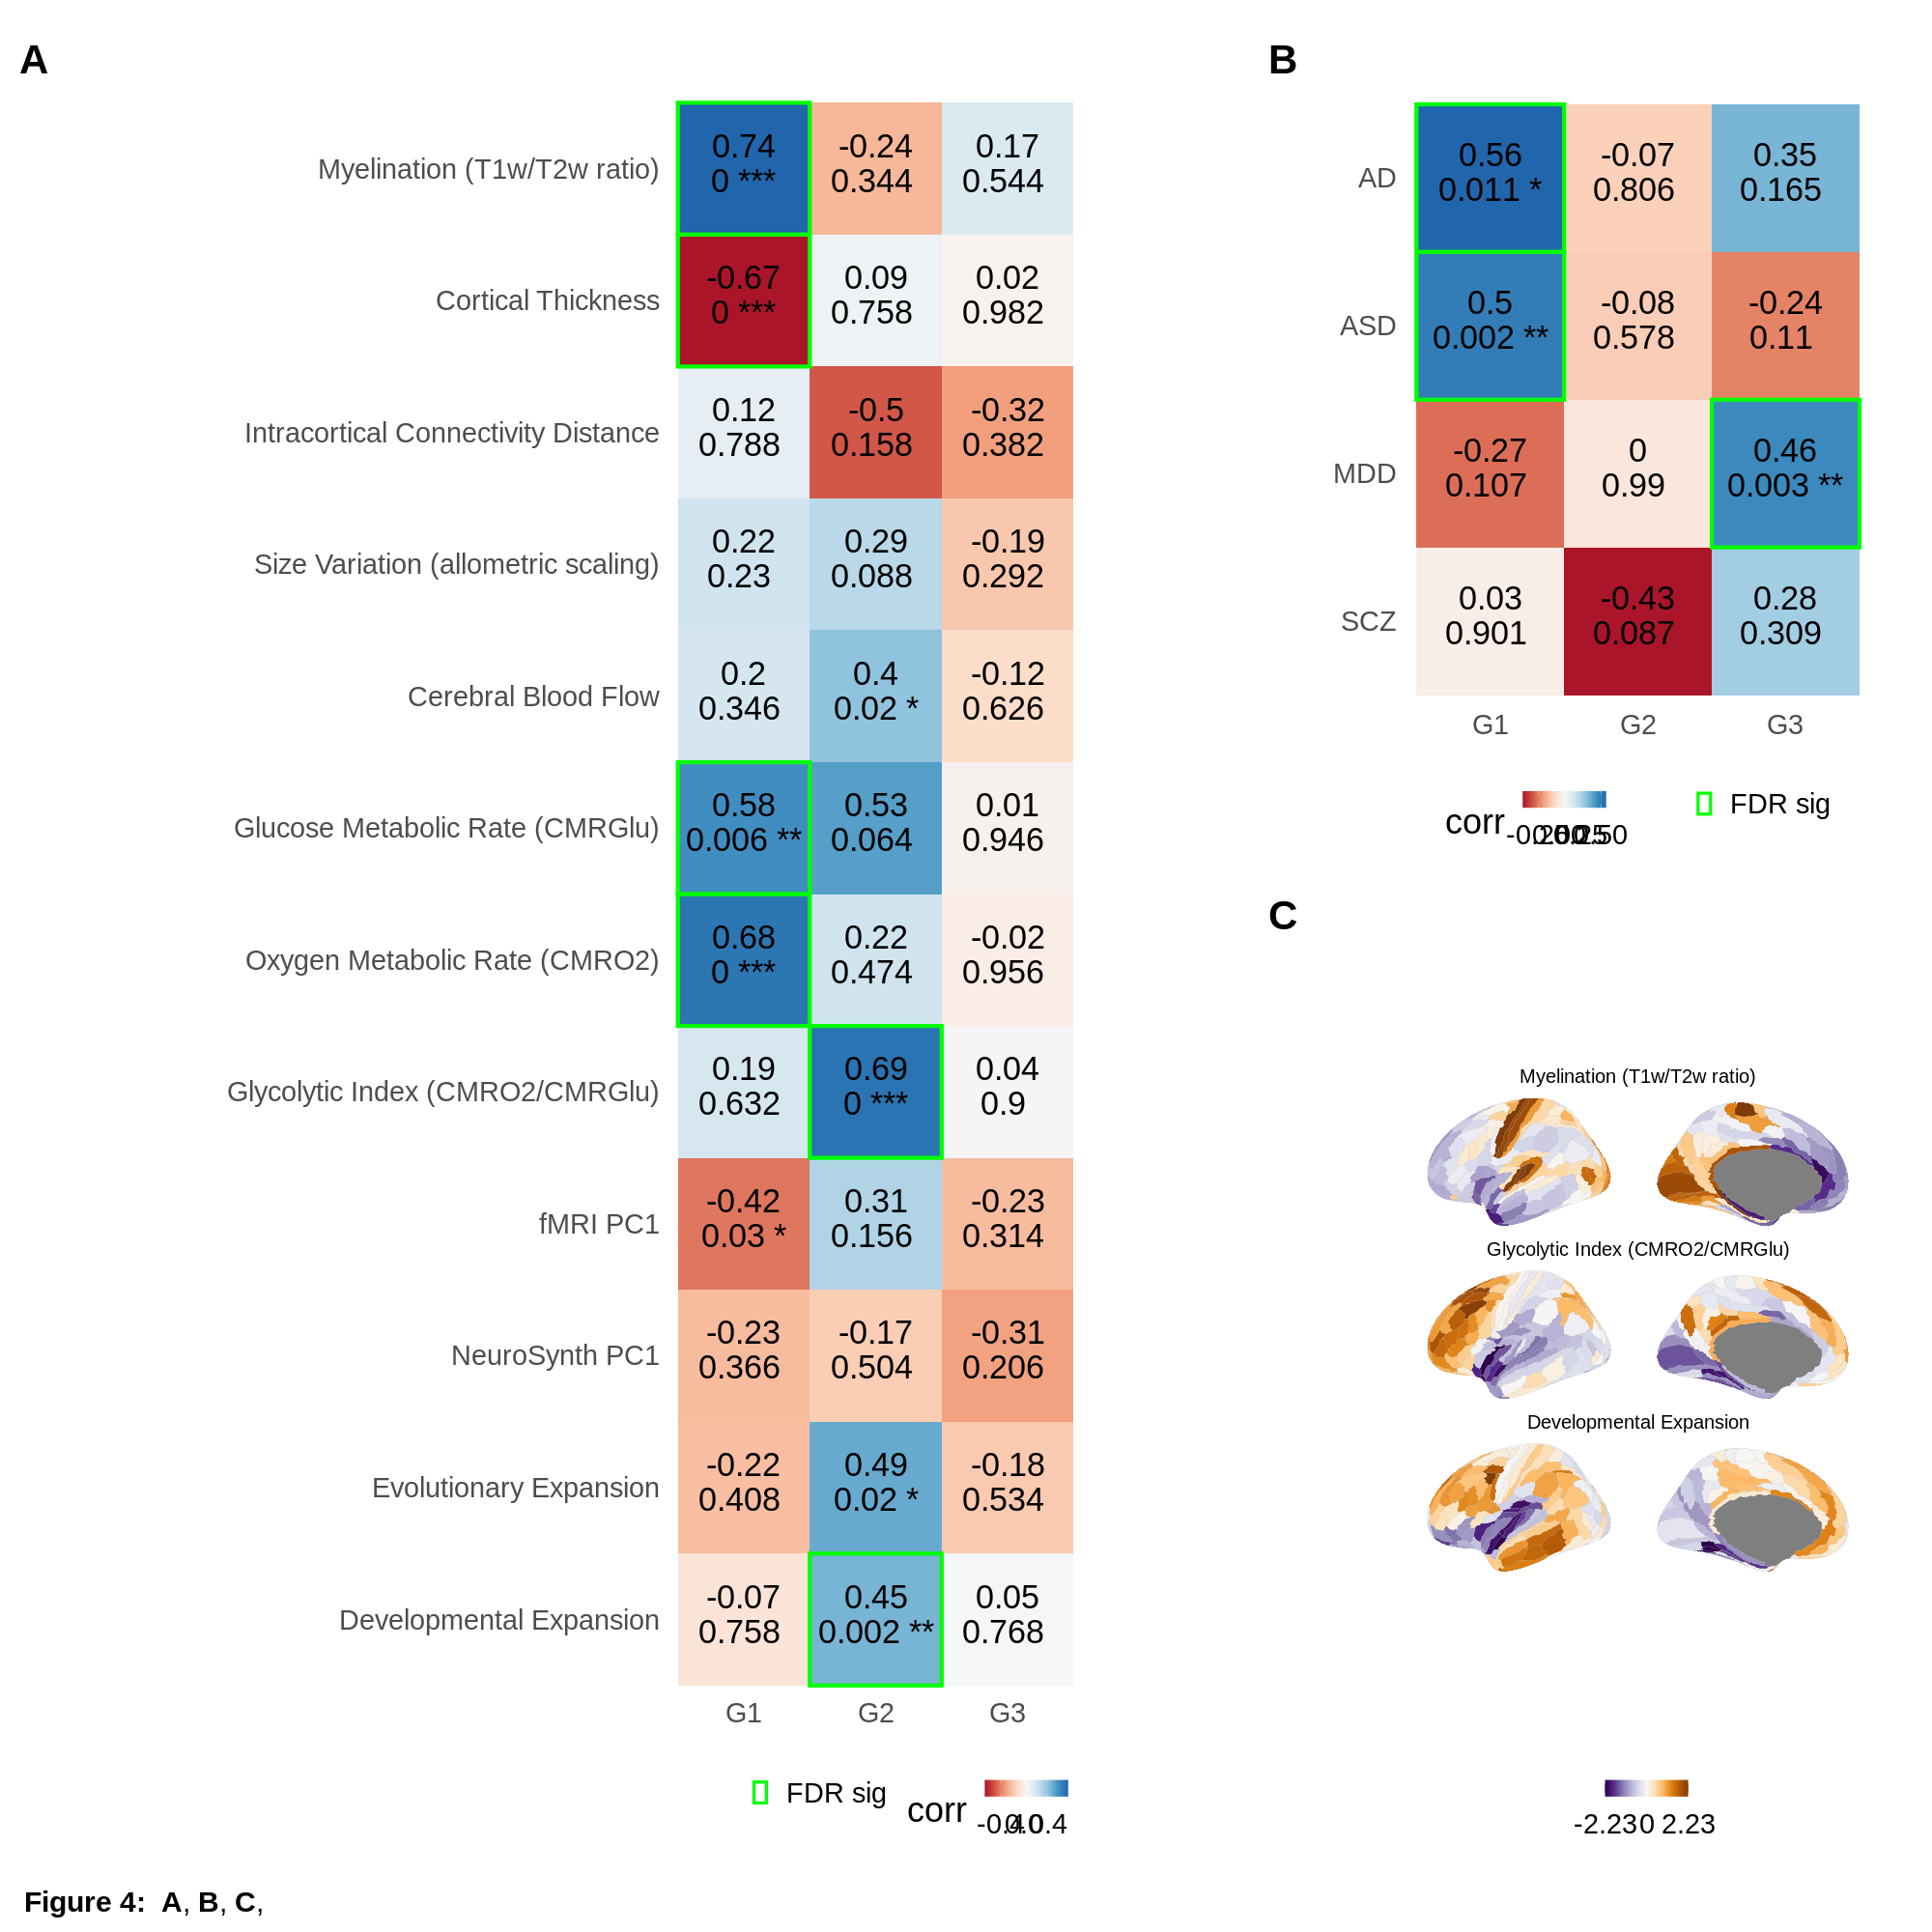

In [191]:
%%R -i mri_corrs -i disorder_corrs -i hcp_maps -w 2000 -h 2000
source("../code/plot_maps.R")
g1 <- plot_corr_versions(mri_corrs, size=12)
g2 <- plot_corr_versions(disorder_corrs, size=12)
g3 <- plot_maps(hcp_maps, ncol=1, colors=rev(brewer.puor(100)))

plot <- (
    g1 | 
    (g2 / g3)
) + plot_layout(widths=c(3,2))

themed <- plot & theme(
    text=element_text(size=36),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)

caption <- paste("**Figure 4:**",
                "**A**, ",
                "**B**, ",
                "**C**, "
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated